In [2]:
import os
from datetime import datetime, time, date
from filemanager import file_ext_search as fes
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
data_path = r'D:\abp53_SBP\segy_RNF\abp53_seb_001_RNF_Po'

pos_files = fes.file_ext_search('.txt', data_path)
print(len(pos_files))

Searching *.txt files in directory:D:\abp53_SBP\segy_RNF\abp53_seb_001_RNF_Po
8


In [4]:
# Reading raw pos
@dataclass
class SegyPosFile:
    name: str
    fin_traceno: int = 0
    datetime: list = field(default_factory=list)
    traceno: list = field(default_factory=list)
    cdp_x: list = field(default_factory=list)
    cdp_x_smoothed: list = field(default_factory=list)
    cdp_y_smoothed: list = field(default_factory=list)
    cdp_x_cartesian_smoothed: list = field(default_factory=list)
    cdp_y_cartesian_smoothed: list = field(default_factory=list)
    cdp_y: list = field(default_factory=list)
    year: list = field(default_factory=list)
    day: list = field(default_factory=list)
    hour: list = field(default_factory=list)
    minute: list = field(default_factory=list)
    second: list = field(default_factory=list)

segy_pos_objs = []
bad_data_dict = {}
fine_data_dict = {}

for pos_file in pos_files:
    segy_name = os.path.splitext(os.path.basename(pos_file))[0][:-7]
    print(segy_name)
    pos_obj = SegyPosFile(name=segy_name)
    number = 0
    
    has_error = False
    was_before = False
    with open(pos_file, 'r') as file1:
        file_content = file1.read().splitlines()
        
        for line in file_content[1:]:
            line_content = line.split()

            try:
                if int(line_content[3]) != 2023:
                    raise RuntimeError('BadYear')
                elif int(int(line_content[4])) > 370 and int(line_content[4]) < 0:
                    raise RuntimeError('BadDay')
                elif float(line_content[1]) < 15.0 and float(line_content[1]) > 50.0:
                    raise RuntimeError('BadCDP_X')
                elif float(line_content[2]) < 30.0 and float(line_content[2]) > 70.0:
                    raise RuntimeError('BadCDP_Y')
                ar = time(hour=int(line_content[5]),
                        minute=int(line_content[6]), second=int(line_content[7]))
            except:
                number += 1
                has_error = True
                if not was_before:
                    bad_data_dict['segy_name'] = pos_obj.traceno[-1]
                    was_before = True
                    
            else:
                pos_obj.datetime.append(f'{line_content[3]}-{line_content[4]}T{line_content[5]}:{line_content[6]}:{line_content[7]}')
                pos_obj.traceno.append(int(line_content[0]))
                pos_obj.cdp_x.append(float(line_content[1]))
                pos_obj.cdp_y.append(float(line_content[2]))
                pos_obj.year.append(int(line_content[3]))
                pos_obj.day.append(int(line_content[4]))
                pos_obj.hour.append(int(line_content[5]))
                pos_obj.minute.append(int(line_content[6]))
                pos_obj.second.append(int(line_content[7]))
                
        fine_data_dict[segy_name] = pos_obj.traceno[-1]
        
        if has_error:
            print(f'Number of bad lines in {segy_name}: {number}')
            
        segy_pos_objs.append(pos_obj)

g.172-177_W2_SLF2305221051_LL_car
g.172-177_W2_SLF2305221052_LL_car
g.172-177_W2_SLF2305221102_LL_car
g.172-177_W2_SLF2305221112_LL_car
g.172-177_W2_SLF2305221122_LL_car
g.172-177_W2_SLF2305221132_LL_car
g.172-177_W2_SLF2305221142_LL_car
g.172-177_W2_SLF2305221152_LL_car


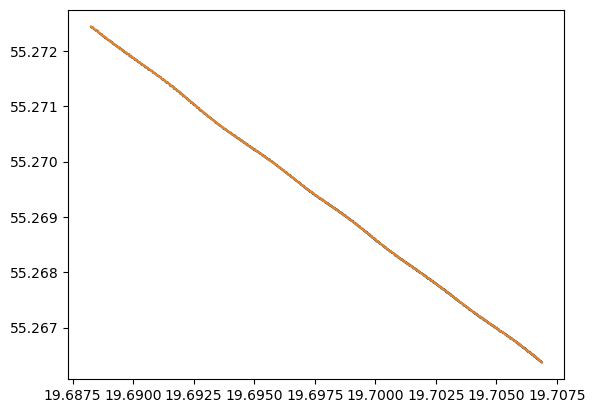

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_track_xy(segy_pos_obj: SegyPosFile):
    x = segy_pos_obj.cdp_x
    y = segy_pos_obj.cdp_y

    y_new = signal.savgol_filter(y,201,3)
    x_new = signal.savgol_filter(x,201,3)
    plt.plot(x,y)
    plt.plot(x_new,y_new)

segy_pos_obj = segy_pos_objs[3]

plot_track_xy(segy_pos_obj)

In [387]:
# Sorting files
SLF_objs = []
PHF_objs= []

for segy_pos_obj in segy_pos_objs:
    if 'SLF' in segy_pos_obj.name:
        SLF_objs.append(segy_pos_obj)
    elif 'PHF' in segy_pos_obj.name:
        PHF_objs.append(segy_pos_obj)

In [388]:
# Track Processing
from pyproj import Proj, CRS, Transformer

crs_wgs84 = CRS.from_epsg(4326)
# crs_utm35n = CRS.from_epsg(32635)
crs_utm34n = CRS.from_epsg(32634)
transformer = Transformer.from_crs(crs_wgs84, crs_utm34n, always_xy=True)

save_to = r'D:\abp53_SBP\segy_RNF\abp53_seb_001_RNF_Po\abp53_seb_001_RNF_Po_track.txt'

with open(save_to, 'w') as file2:
    file2.write('num_o,num_i,name,datetime,traceno,cdp_x,cdp_y,year,day,hour,minute,second\n')
    num_o = 0
    num_f = 0
    for segy_pos_obj in SLF_objs:
        window_length = 201
        file_length = len(segy_pos_obj.cdp_x)
        
        loop = True
        while loop:
            if window_length > file_length/4:
                window_length = int(window_length/4)
            elif window_length < 10:
                loop = False
            else:
                loop = False
        
        if window_length < 10:
            print(f'Can not smooth file {segy_pos_obj.name}')
            cartesian_x, cartesian_y = transformer.transform(segy_pos_obj.cdp_x, segy_pos_obj.cdp_y)
            if '_not_smoothed' in segy_pos_obj.name:
                pass
            else:
                segy_pos_obj.name = segy_pos_obj.name + '_not_smoothed'
            
            segy_pos_obj.cdp_x_cartesian_smoothed = cartesian_x
            segy_pos_obj.cdp_y_cartesian_smoothed = cartesian_y
        
        else:
            segy_pos_obj.cpd_x_smoothed = signal.savgol_filter(segy_pos_obj.cdp_x,window_length,3)
            segy_pos_obj.cpd_y_smoothed = signal.savgol_filter(segy_pos_obj.cdp_y,window_length,3)
            
            cartesian_x, cartesian_y = transformer.transform(segy_pos_obj.cpd_x_smoothed, segy_pos_obj.cpd_y_smoothed)
        
            segy_pos_obj.cdp_x_cartesian_smoothed = cartesian_x.tolist()
            segy_pos_obj.cdp_y_cartesian_smoothed = cartesian_y.tolist()
        
        for num_i,traceno in enumerate(segy_pos_obj.traceno):
            file2.write(f'{num_o},{num_i},{segy_pos_obj.name},{segy_pos_obj.datetime[num_i]},{segy_pos_obj.traceno[num_i]},{segy_pos_obj.cdp_x_cartesian_smoothed[num_i]},')
            file2.write(f'{segy_pos_obj.cdp_y_cartesian_smoothed[num_i]},{segy_pos_obj.year[num_i]},{segy_pos_obj.day[num_i]},{segy_pos_obj.hour[num_i]},{segy_pos_obj.minute[num_i]},')
            file2.write(f'{segy_pos_obj.second[num_i]}\n')
            num_o += 1
        num_f += 1
        print(f'File {segy_pos_obj.name} is done {num_f} of {len(segy_pos_objs)}')

File g_189-2_W2_SLF2305230155_LL_car is done 1 of 7
File g_189-2_W2_SLF2305230205_LL_car is done 2 of 7
File g_189-2_W2_SLF2305230215_LL_car is done 3 of 7
File g_189-2_W2_SLF2305230225_LL_car is done 4 of 7
File g_189-2_W2_SLF2305230235_LL_car is done 5 of 7
File g_189-2_W2_SLF2305230245_LL_car is done 6 of 7
File g_189-2_W2_SLF2305230255_LL_car is done 7 of 7


In [389]:
# Save proc pos
sgy_files = fes.file_ext_search('.sgy', data_path)

for sgy_file in sgy_files:
    
    filename = os.path.splitext(os.path.basename(sgy_file))[0]
    
    for slf_obj in SLF_objs:
        if slf_obj.name == filename:
            with open(os.path.join(data_path, filename + '.procpos'), 'w') as file3:
                file3.write(f'TraceNo\tCDPX\tCDPY\tBADTRACESTART\n')
                for num, cdp_x in enumerate(slf_obj.cdp_x_cartesian_smoothed):
                    file3.write(f'{slf_obj.traceno[num]}\t{slf_obj.cdp_x_cartesian_smoothed[num]}\t{slf_obj.cdp_y_cartesian_smoothed[num]}\n')


RuntimeError: Path either not exists or not correct D:\abp53_SBP\segy_RNF\abp53_seb_014_RNF_Po

In [390]:
# Replica creation
replica_path = r'D:\abp53_SBP\segy_RNF\replica.txt'

has_header = False

if os.path.exists(replica_path):
    has_header = True
    print('file exists')

with open(replica_path, 'a') as file4:
    if has_header:
        file4.write('prof_folder\tfile_name\tfile_name_proc\tprof_name\n')
    
    for sgy_file in sgy_files:
        filename = os.path.splitext(os.path.basename(sgy_file))[0]
        prof_folder = data_path
        prof_name = os.path.split(data_path)[1]
        filename_proc = filename + '_proc'
        
        file4.write(f'{prof_folder}\t{filename}\t{filename_proc}\t{prof_name}\n')

file exists
